<a href="https://colab.research.google.com/github/parmarsuraj99/numereval/blob/master/examples/evaluating_numereval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluating Numereval

In [ ]:
!pip install numerapi
!pip install numereval

## Loading Libraries

In [5]:
import os
import re
import gc
import csv
import glob
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

import numerapi

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
napi = numerapi.NumerAPI(verbosity="info")
napi.download_current_dataset(unzip=True)

latest_round = napi.get_current_round()
current_ds = os.path.join('numerai_dataset_'+str(latest_round),'')

./numerai_dataset_247.zip: 387MB [00:04, 82.2MB/s]                           
2021-01-21 03:13:38,620 INFO numerapi.base_api: unzipping file...


In [7]:
TOURNAMENT_NAME = "nomi"
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"

# Submissions are scored by spearman correlation
def correlation(predictions, targets):
    ranked_preds = predictions.rank(pct=True, method="first")
    return np.corrcoef(ranked_preds, targets)[0, 1]


# convenience method for scoring
def score(df):
    return correlation(df[PREDICTION_NAME], df[TARGET_NAME])


# Payout is just the score cliped at +/-25%
def payout(scores):
    return scores.clip(lower=-0.25, upper=0.25)


# Read the csv file into a pandas Dataframe as float16 to save space
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))

    dtypes = {x: np.float16 for x in column_names if x.startswith(('feature', 'target'))}
    df = pd.read_csv(file_path, dtype=dtypes, index_col=0)

    return df


In [8]:
%%time
print("Loading data...")

training_data = read_csv(f"{current_ds}/numerai_training_data.csv")
tournament_data = read_csv(f"{current_ds}/numerai_tournament_data.csv")
example_preds = read_csv(f"{current_ds}/example_predictions.csv")
validation_data = tournament_data[tournament_data.data_type == "validation"]

feature_names = [
    f for f in training_data.columns if f.startswith("feature")
]
print(f"Loaded {len(feature_names)} features")

Loading data...
Loaded 310 features
CPU times: user 52.8 s, sys: 2.86 s, total: 55.7 s
Wall time: 1min


## predictions

In [9]:
print("Generating predictions...")
training_data[PREDICTION_NAME] = np.random.random((len(training_data)))
tournament_data[PREDICTION_NAME] = np.random.random((len(tournament_data)))

Generating predictions...


In [10]:
from numereval import numereval

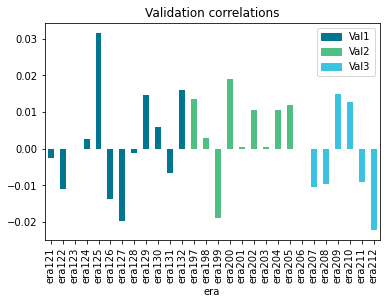

,0
mean,0.001518
std,0.012918
sharpe,0.117549
max_drawdown,-0.035047
max_feature_exp,0.040482
feature_exposure,0.002263
mmc_mean,0.001120
corr_plus_mmc_sharpe,0.116091
corr_plus_mmc_diff,-0.001458


In [13]:
validation_data = tournament_data[tournament_data.data_type=="validation"]
numereval.diagnostics(validation_data, plot=True, 
                                example_preds_loc=f"/content/numerai_dataset_{latest_round}/example_predictions.csv")

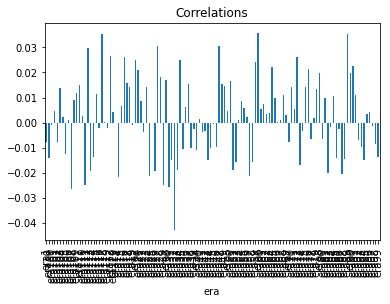

,0
mean,0.001901
std,0.015564
sharpe,0.122136
max_drawdown,-0.152848
max_feature_exp,0.044698
feature_exposure,0.001469


In [14]:
numereval.evaluate(training_data, plot=True, feature_exposure=True)

---

Future work: More customization and Signals metrics